In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [18]:
eta = 0.0001
beta1 = 0.9
beta2 = 0.999
threshold = (2 + 2 * beta1) / (eta * (1 - beta1))

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        activation = nn.Tanh()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 200),
            activation,
            nn.Linear(200, 200),
            activation,
            nn.Linear(200, 200),
            activation,
            nn.Linear(200, 200),
            activation,
            nn.Linear(200, 200),
            activation,
            nn.Linear(200, 10)
        )

    def forward(self, x):
        return self.layers(x)

transform = transforms.ToTensor()
full_train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

device = torch.device("cuda")
model = MLP().to(device)

#subset_indices = list(range(len(full_train_dataset)))
subset_indices = list(range(12000))
train_subset = torch.utils.data.Subset(full_train_dataset, subset_indices)

print(f"Using a subset of {len(train_subset)} images.")

full_batch_loader = DataLoader(
    dataset = train_subset,
    batch_size = len(train_subset),
    shuffle = True
)

X_full, y_full = next(iter(full_batch_loader))
X_full = X_full.to(device)
y_full = y_full.to(device)

print(f"Data batch shape (X): {X_full.shape}") # Should be [1000, 1, 28, 28]
print(f"Data labels shape (y): {y_full.shape}") # Should be [1000]

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr = eta,
    betas = (beta1, beta2)
)

Using a subset of 12000 images.
Data batch shape (X): torch.Size([12000, 1, 28, 28])
Data labels shape (y): torch.Size([12000])


In [19]:
def get_preconditioned_sharpness(model, loss_fn, optimizer, X_batch, y_batch):
    
    def Hvp_fn(v): # Product H*v (Hessian * vector)
        model.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        grads1 = torch.autograd.grad(loss, model.parameters(), create_graph = True)
        grads1_flat = torch.cat([g.view(-1) for g in grads1])

        g_v_dot = (grads1_flat * v).sum()
        hvp = torch.autograd.grad(g_v_dot, model.parameters(), retain_graph = True)
        hvp_flat = torch.cat([h.view(-1) for h in hvp])

        return hvp_flat.detach()
    
    p_inv_flat_list = []
    eps = optimizer.param_groups[0]['eps']
    beta2 = optimizer.param_groups[0]['betas'][1]

    for param in model.parameters():
        if param in optimizer.state:
            state = optimizer.state[param]
            if 'exp_avg_sq' in state:
                v_t = state['exp_avg_sq']
                p_inv_t = 1.0 / (torch.sqrt(v_t) + eps)
                
                p_inv_flat_list.append(p_inv_t.view(-1))

    if not p_inv_flat_list:
        return 0.0
            
    p_inv_flat = torch.cat(p_inv_flat_list)

    num_params = p_inv_flat.size(0)
    v = torch.randn(num_params, device = X_batch.device)

    num_iterations = 10

    for _ in range(num_iterations):
        v = v / torch.norm(v)
        H_v = Hvp_fn(v)
        z = p_inv_flat * H_v
        eigenvalue = torch.dot(v, z)
        v = z

    return eigenvalue.item()

def run_experiment(eta, beta1, beta2, n_steps=1000):
    print(f"--- Running experiment: eta={eta}, beta1={beta1}, beta2={beta2} ---")
    
    model = MLP().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=eta, betas=(beta1, beta2))
    
    train_losses = []
    sharpness_values = []

    for step in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X_full)
        loss = loss_fn(y_pred, y_full)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if step > 0:
            sharpness = get_preconditioned_sharpness(model, loss_fn, optimizer, X_full, y_full)
            sharpness_values.append(sharpness)
        else:
            sharpness_values.append(0.0)
        
        if step % 200 == 0 or step == n_steps - 1:
            print(f"  Step {step}/{n_steps} | Loss: {loss.item():.4f} | Sharpness: {sharpness_values[-1]:.2f}")

    return train_losses, sharpness_values

# Figure 1

## Varying eta

--- Running experiment: eta=3e-05, beta1=0.9, beta2=0.999 ---
  Step 0/500 | Loss: 2.3018 | Sharpness: 0.00
  Step 200/500 | Loss: 1.2678 | Sharpness: 50164.60
  Step 400/500 | Loss: 0.7626 | Sharpness: 58039.58
  Step 499/500 | Loss: 0.5996 | Sharpness: 58719.42
--- Running experiment: eta=0.0001, beta1=0.9, beta2=0.999 ---
  Step 0/500 | Loss: 2.3012 | Sharpness: 0.00
  Step 200/500 | Loss: 0.4043 | Sharpness: 93416.66
  Step 400/500 | Loss: 0.2024 | Sharpness: 139370.39
  Step 499/500 | Loss: 0.1411 | Sharpness: 198035.38
--- Running experiment: eta=0.00032, beta1=0.9, beta2=0.999 ---
  Step 0/500 | Loss: 2.3054 | Sharpness: 0.00
  Step 200/500 | Loss: 0.1254 | Sharpness: 216010.97
  Step 400/500 | Loss: 0.0140 | Sharpness: 132330.69
  Step 499/500 | Loss: 0.0053 | Sharpness: 84518.02
--- Running experiment: eta=0.001, beta1=0.9, beta2=0.999 ---
  Step 0/500 | Loss: 2.3037 | Sharpness: 0.00
  Step 200/500 | Loss: 0.0141 | Sharpness: 70215.86
  Step 400/500 | Loss: 0.0008 | Sharpness

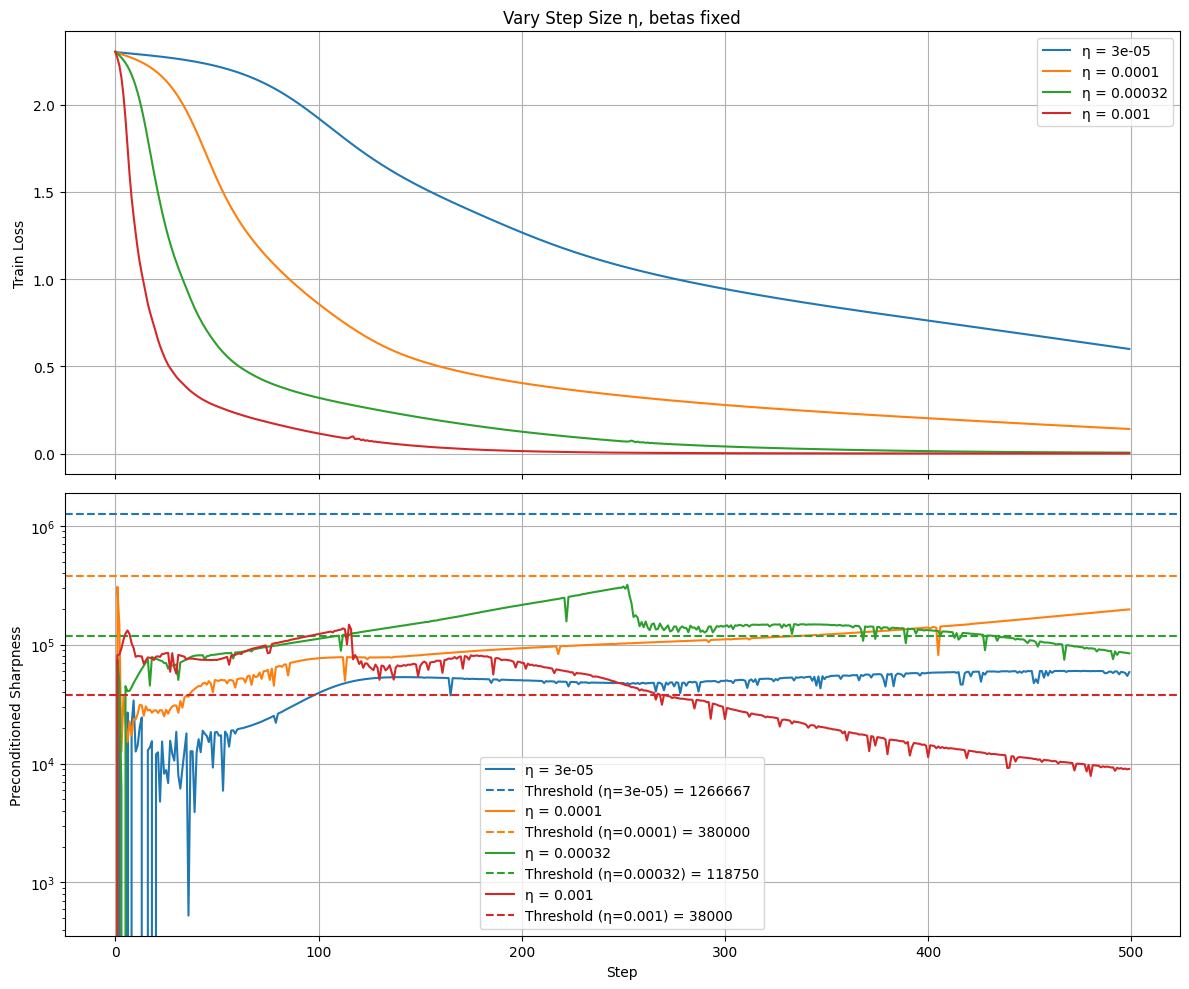

In [20]:
eta_list = [0.00003, 0.0001, 0.00032, 0.001]
beta1_fixed = 0.9
beta2_fixed = 0.999
n_steps = 500

results_by_eta = {}

for eta_val in eta_list:
    threshold = (2 + 2 * beta1_fixed) / (eta_val * (1 - beta1_fixed))
    losses, sharpness = run_experiment(eta_val, beta1_fixed, beta2_fixed, n_steps)
    
    results_by_eta[eta_val] = {
        'losses': losses,
        'sharpness': sharpness,
        'threshold': threshold
    }

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for i, (eta_val, results) in enumerate(results_by_eta.items()):
    label = f'η = {eta_val}'
    
    ax1.plot(results['losses'], label=label)
    steps_to_plot = range(n_steps)
    sharpness_line = ax2.plot(steps_to_plot, results['sharpness'], label=label)
    line_color = sharpness_line[0].get_color()
    
    ax2.axhline(y=results['threshold'], linestyle='--', 
                color=line_color,
                label=f'Threshold (η={eta_val}) = {results["threshold"]:.0f}')

ax1.set_ylabel('Train Loss')
ax1.set_title('Vary Step Size η, betas fixed')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Step')
ax2.set_ylabel('Preconditioned Sharpness')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Varying beta1

--- Running experiment: eta=0.0001, beta1=0.95, beta2=0.999 ---
  Step 0/1000 | Loss: 2.3031 | Sharpness: 0.00
  Step 200/1000 | Loss: 0.4543 | Sharpness: 57271.05
  Step 400/1000 | Loss: 0.2265 | Sharpness: 65285.04
  Step 600/1000 | Loss: 0.1254 | Sharpness: 113154.65
  Step 800/1000 | Loss: 0.0554 | Sharpness: 166680.66
  Step 999/1000 | Loss: 0.0207 | Sharpness: 180789.05
--- Running experiment: eta=0.0001, beta1=0.902, beta2=0.999 ---
  Step 0/1000 | Loss: 2.3021 | Sharpness: 0.00
  Step 200/1000 | Loss: 0.3850 | Sharpness: 58469.12
  Step 400/1000 | Loss: 0.2014 | Sharpness: 84247.80
  Step 600/1000 | Loss: 0.0987 | Sharpness: 148951.86
  Step 800/1000 | Loss: 0.0361 | Sharpness: 207323.75
  Step 999/1000 | Loss: 0.0124 | Sharpness: 170335.03
--- Running experiment: eta=0.0001, beta1=0.814, beta2=0.999 ---
  Step 0/1000 | Loss: 2.3023 | Sharpness: 0.00
  Step 200/1000 | Loss: 0.3907 | Sharpness: 97811.74
  Step 400/1000 | Loss: 0.1953 | Sharpness: 146126.09
  Step 600/1000 | Loss

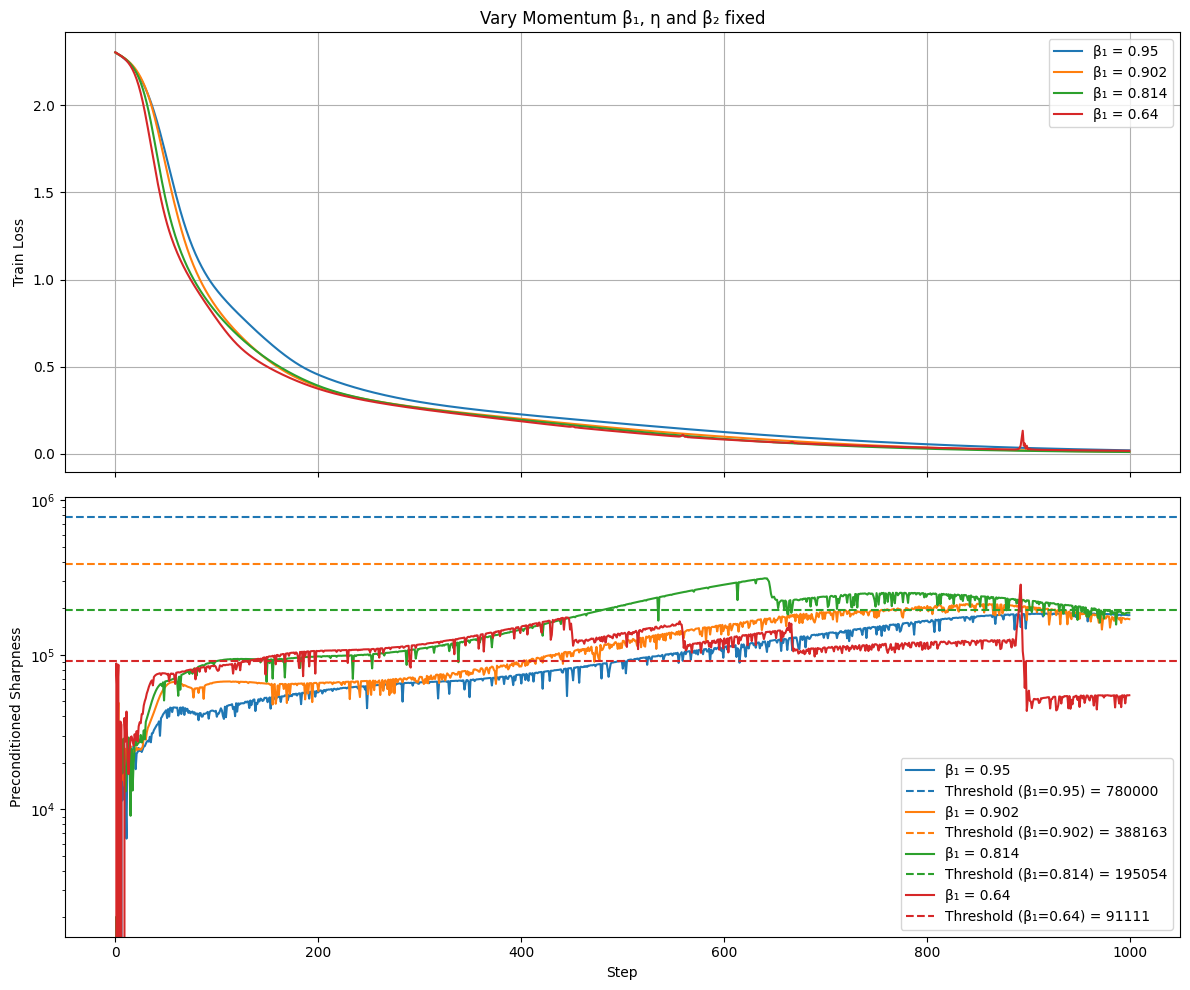

In [ ]:
beta1_list = [0.950, 0.902, 0.814, 0.640]
eta_fixed = 0.0001
beta2_fixed = 0.999
n_steps = 2000

results_by_beta1 = {}

for beta1_val in beta1_list:
    threshold = (2 + 2 * beta1_val) / (eta_fixed * (1 - beta1_val))
    losses, sharpness = run_experiment(eta_fixed, beta1_val, beta2_fixed, n_steps)
    
    results_by_beta1[beta1_val] = {
        'losses': losses,
        'sharpness': sharpness,
        'threshold': threshold
    }

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for i, (beta1_val, results) in enumerate(results_by_beta1.items()):
    label = f'β₁ = {beta1_val}'
    
    ax1.plot(results['losses'], label=label)
    
    steps_to_plot = range(n_steps)
    
    sharpness_line = ax2.plot(steps_to_plot, results['sharpness'], label=label)
    
    line_color = sharpness_line[0].get_color()
    
    ax2.axhline(y=results['threshold'], linestyle='--', 
                color=line_color,
                label=f'Threshold (β₁={beta1_val}) = {results["threshold"]:.0f}')

ax1.set_ylabel('Train Loss')
ax1.set_title('Vary Momentum β₁, η and β₂ fixed')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Step')
ax2.set_ylabel('Preconditioned Sharpness')
ax2.set_yscale('log')
ax2.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()

--- Running experiment: eta=5e-05, beta1=0.9, beta2=0.9 ---
  Step 0/10 | Loss: 2.3067 | Sharpness: 0.00
  Step 9/10 | Loss: 2.2898 | Sharpness: 2570.51
--- Running experiment: eta=5e-05, beta1=0.9, beta2=0.99 ---
  Step 0/10 | Loss: 2.3034 | Sharpness: 0.00
  Step 9/10 | Loss: 2.2865 | Sharpness: 2188.80
--- Running experiment: eta=5e-05, beta1=0.9, beta2=0.999 ---
  Step 0/10 | Loss: 2.3029 | Sharpness: 0.00
  Step 9/10 | Loss: 2.2854 | Sharpness: 8299.00
--- Running experiment: eta=0.0004, beta1=0.9, beta2=0.9 ---
  Step 0/10 | Loss: 2.3036 | Sharpness: 0.00
  Step 9/10 | Loss: 2.0744 | Sharpness: 7956.83
--- Running experiment: eta=0.0004, beta1=0.9, beta2=0.999 ---
  Step 0/10 | Loss: 2.3028 | Sharpness: 0.00
  Step 9/10 | Loss: 2.0624 | Sharpness: 60537.02


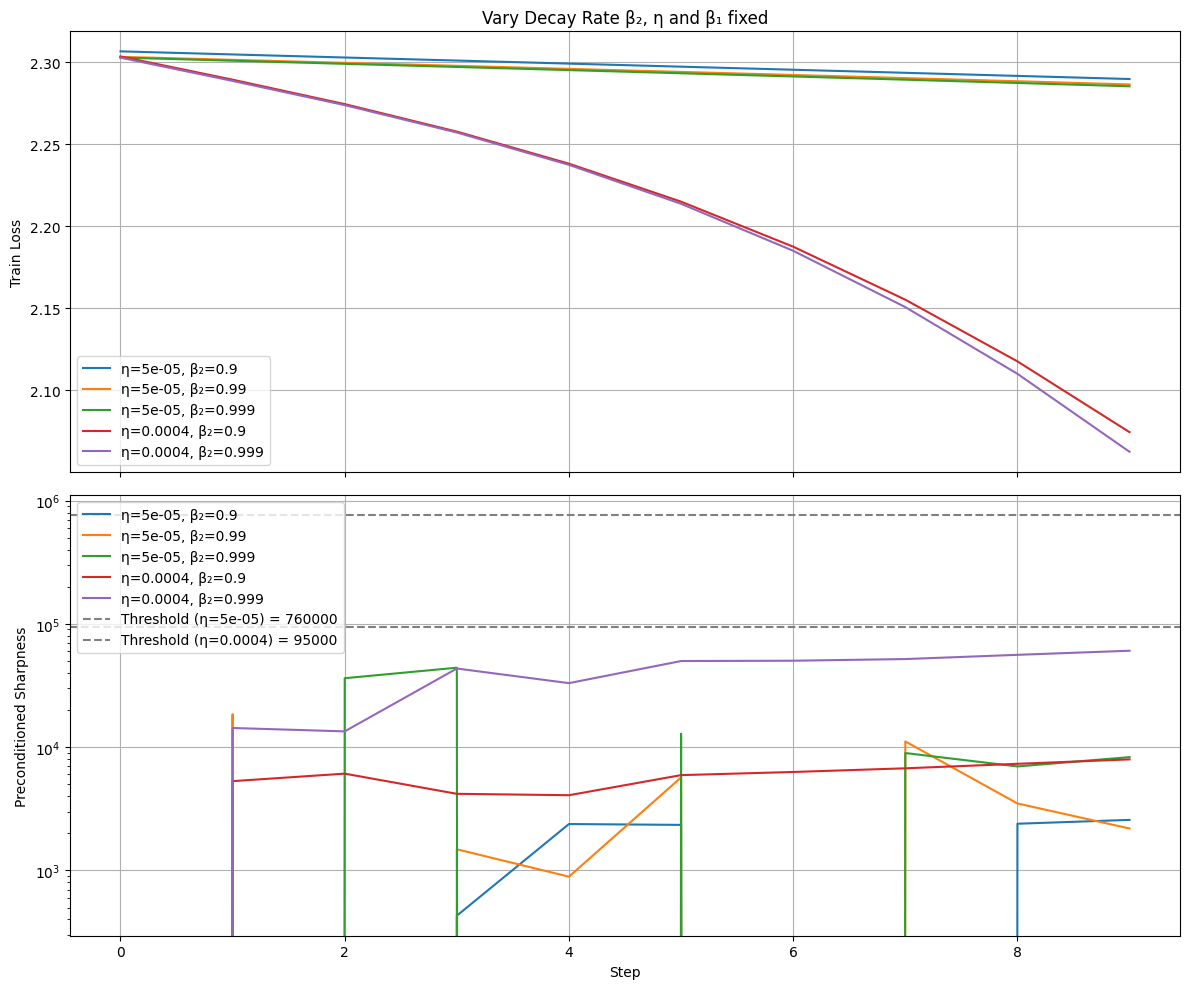

In [ ]:
run_list = [
    {'eta': 5e-5, 'beta1': 0.9, 'beta2': 0.9},
    {'eta': 5e-5, 'beta1': 0.9, 'beta2': 0.99},
    {'eta': 5e-5, 'beta1': 0.9, 'beta2': 0.999},
    {'eta': 4e-4, 'beta1': 0.9, 'beta2': 0.9},
    {'eta': 4e-4, 'beta1': 0.9, 'beta2': 0.999},
]
n_steps = 2000

results_by_run = {}
thresholds = {}

for run_params in run_list:
    eta_val = run_params['eta']
    beta1_val = run_params['beta1']
    beta2_val = run_params['beta2']
    
    run_key = f"eta={eta_val}_b2={beta2_val}"
    
    if eta_val not in thresholds:
        thresholds[eta_val] = (2 + 2 * beta1_val) / (eta_val * (1 - beta1_val))
        
    losses, sharpness = run_experiment(eta_val, beta1_val, beta2_val, n_steps)
    
    results_by_run[run_key] = {
        'params': run_params,
        'losses': losses,
        'sharpness': sharpness,
    }

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)


for i, (run_key, results) in enumerate(results_by_run.items()):
    eta = results['params']['eta']
    b2 = results['params']['beta2']
    label = f'η={eta}, β₂={b2}'
    
    
    ax1.plot(results['losses'], label=label)
    
    steps_to_plot = range(n_steps)
    
    ax2.plot(steps_to_plot, results['sharpness'], label=label)

for eta_val, thresh_val in thresholds.items():
    ax2.axhline(y=thresh_val, linestyle='--', color='gray', 
                label=f'Threshold (η={eta_val}) = {thresh_val:.0f}')

ax1.set_ylabel('Train Loss')
ax1.set_title('Vary Decay Rate β₂, η and β₁ fixed')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Step')
ax2.set_ylabel('Preconditioned Sharpness')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()